In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
# Se importan librerías para graficar.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from keras import backend as K
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Input
import keras.regularizers
from tensorflow.keras import optimizers

In [2]:
df = pd.read_csv('diabetes.csv')

In [3]:
correlations = df.corr()
correlations['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64

In [4]:
def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sens_keras = true_positives / (possible_positives + K.epsilon())
    return sens_keras

def positive_predictive_value(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    ppv_keras = true_positives / (predicted_positives + K.epsilon())
    return ppv_keras

In [5]:
def plot_loss(history):
    # Plot the training loss.
    plt.plot(history.history['loss'], 'r-')

    # Plot the validation loss.
    plt.plot(history.history['val_loss'], 'b-')

    # X-axis label.
    plt.xlabel('Epochs')

    # Y-axis label.
    plt.ylabel('Cost')

    # Graph legend.
    plt.legend(["Training loss", "Validation loss"])

    # Graph title.
    plt.title('Loss Graph')

    plt.show()

In [6]:
class DiabetesPredictor:
    def __init__(self, df, replaceOutliers=False, deleteRowsWithOutliers=False, replaceNulls=False,deleteRowsWithNulls=False, nullColumns=[], outliersColumns=[], columnsToRemove=[]):
        """DiabetesPredictor

    This is a class contains the most part of the methods needed for the diabetes predictor,
    first get the data of the csv file and then perform some methods to clean the data insid
    and allows you to choose if it has to replace outliers or not and replace nulls values or not.


    Attributes:
        replace_outliers: Use the string "replace_outliers" if you want to do that on your model with the median value
        replace_nulls: Use the string "replace_nulls" to replace all nulls in your model with the median value
        delete_row_with_outliers: Use the string "delete_row_with_outliers" to replace all the rows that contains outliers
    """
        self.df = df
        if(replaceOutliers):
            self.__replace_outliers__(outliersColumns)
        elif(deleteRowsWithOutliers): 
            self.__delete_row_with_outliers__(outliersColumns)
        if(replaceNulls):
            self.__replace_nulls__(nullColumns)
        elif (deleteRowsWithNulls):
            self.__delete_row_with_nulls__(nullColumns)
        
        self.__remove_columns__(columnsToRemove)
        self.__separate_data_and_labels__()
        self.__normalize_data__()
        self.__split_train_test__()
        self.__find_best_hyperparams__()
        
    def __separate_data_and_labels__(self):
        df_values = self.df.values
        self.x = df_values[:,:-1]
        self.y = df_values[:, -1].reshape(self.x.shape[0], 1)
    
    def __replace_outliers__(self, cols):
        #Para cada columna (excepto para el Outcome) se reemplazan los outliers por su mediana.
        for col in cols:
            #Cálculo de parámetros para obtener los outliers.
            q1 = self.df[col].quantile(0.25)
            q3 = self.df[col].quantile(0.75)
            iqr = q3-q1
            #Límites de los valores tipicos.
            Lower_tail = q1 - 1.5 * iqr
            Upper_tail = q3 + 1.5 * iqr
            #Cálculo de la mediana.
            med = np.median(self.df[col])
            #Reemplazo.
            for i in self.df[col]:
                if i > Upper_tail or i < Lower_tail:
                        self.df[col] = self.df[col].replace(i, med)

    def __replace_nulls__(self, cols):
        columns = cols
        self.df[columns] = self.df[columns].replace(0,np.NaN)
        median=self.df[columns].median()
        self.df[columns]=self.df[columns].replace(np.NaN,median)

    def __remove_columns__(self, cols):
        self.df = self.df.drop(cols, axis=1)
    
    def __normalize_data__(self):
        # Mean, columnar axis.
        x_mean = np.mean(self.x, axis=0, keepdims=True)
        # Std. Deviation, columnar axis.
        x_std = np.std(self.x, axis=0, keepdims=True)
        # Normalizing.
        self.x = (self.x - x_mean)/x_std

    def __split_train_test__(self):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=0.1, random_state=5)

    def __model_builder__(self,hp):
        model = Sequential()
        model.add(Dense(1,activation='sigmoid', input_shape=(self.x.shape[1],)))

        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_momentum = hp.Choice('momentum',values=[0.9, 0.99, 0.999])
        hp_learning_rate = hp.Choice('learning_rate', values=[1.0, 0.1, 1e-2, 1e-3, 1e-4, 1e-5])
        

        model.compile(optimizer=optimizers.SGD(momentum=hp_momentum, learning_rate=hp_learning_rate, ),
                        loss=keras.losses.BinaryCrossentropy(),
                        metrics=[tf.keras.metrics.AUC()])

        return model

    def __find_best_hyperparams__(self):
        self.tuner = kt.Hyperband(self.__model_builder__,
                     kt.Objective("val_loss", direction="min"),
                     max_epochs=10,
                     factor=3,
                     project_name='redes1',
                     directory='saved_models'
                     )
        self.tuner.search(self.x_train, self.y_train, epochs=50, validation_split=0.2)
        self.best_hps=self.tuner.get_best_hyperparameters(num_trials=2)[0]

    def get_best_hyperparams(self):
        return 'Learning Rate: ' + str(self.best_hps.get('learning_rate')) + '   --   Momentum: ' + str(self.best_hps.get('momentum'))

    def train_model(self):
        model = self.tuner.hypermodel.build(self.best_hps)
        history = model.fit(self.x_train, self.y_train, epochs=50, validation_split=0.2, verbose=0)
        plot_loss(history)
        val_acc_per_epoch = history.history['val_loss']
        best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
        print('Best epoch: %d' % (best_epoch,))
        #plot_loss(history)
        self.hypermodel = self.tuner.hypermodel.build(self.best_hps)

        # Retrain the model
        self.hypermodel.fit(self.x_train, self.y_train, epochs=best_epoch, validation_split=0.2)

    def test_model(self):
        self.predictions = self.hypermodel.predict(self.x_test)
        self.fpr_keras, self.tpr_keras, self.thresholds_keras = roc_curve(self.y_test, self.predictions)
        self.auc_keras = auc(self.fpr_keras, self.tpr_keras)
        return self.auc_keras

    def plot_roc(self):
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(self.fpr_keras, self.tpr_keras, label='Keras (area = {:.3f})'.format(self.auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()

    def get_metrics(self):
        print('AUC ' + str(self.auc_keras))
        rounded_preds = np.rint(self.predictions)
        print('Specificity: ' + str(specificity(self.y_test.astype(float),  rounded_preds.astype(float))))
        print('Sensitivity: ' + str(sensitivity(self.y_test.astype(float),  rounded_preds.astype(float))))
        print('Positive Predictive Value: ' + str(positive_predictive_value(self.y_test.astype(float), rounded_preds.astype(float))))
        print('Negative Predictive Value: ' + str(negative_predictive_value(self.y_test.astype(float), rounded_preds.astype(float))))
    
    def __delete_row_with_outliers__(self, cols):
        #Para cada columna (excepto para el Outcome) se buscan los outliers para borrar la fila
        for col in cols:
            #Cálculo de parámetros para obtener los outliers.
            q1 = self.df[col].quantile(0.25)
            q3 = self.df[col].quantile(0.75)
            iqr = q3-q1
            #Límites de los valores tipicos.
            Lower_tail = q1 - 1.5 * iqr
            Upper_tail = q3 + 1.5 * iqr
            #Cálculo de la mediana.
            med = np.median(self.df[col])

            self.df = self.df[Lower_tail < self.df[col] < Upper_tail]

    def __delete_row_with_nulls__(self, cols):
        for col in cols:
            self.df = self.df[self.df[col] is not np.NaN]

In [7]:
predictor = DiabetesPredictor(df)

INFO:tensorflow:Reloading Oracle from existing project saved_models\redes1\oracle.json
INFO:tensorflow:Reloading Tuner from saved_models\redes1\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [8]:
predictor.get_best_hyperparams()

'Learning Rate: 0.01   --   Momentum: 0.99'

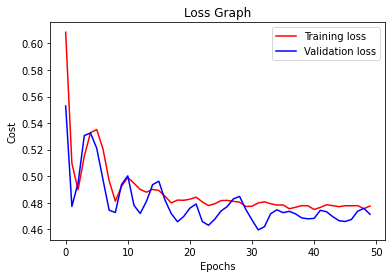

Best epoch: 32
Epoch 1/32
18/18 [==============================] - 2s 47ms/step - loss: 0.9438 - auc: 0.4183 - val_loss: 0.7647 - val_auc: 0.5615
Epoch 2/32
18/18 [==============================] - 0s 4ms/step - loss: 0.5749 - auc: 0.7434 - val_loss: 0.5133 - val_auc: 0.8206
Epoch 3/32
18/18 [==============================] - 0s 4ms/step - loss: 0.5574 - auc: 0.8161 - val_loss: 0.5380 - val_auc: 0.8382
Epoch 4/32
18/18 [==============================] - 0s 6ms/step - loss: 0.6117 - auc: 0.8256 - val_loss: 0.6012 - val_auc: 0.8363
Epoch 5/32
18/18 [==============================] - 0s 5ms/step - loss: 0.6187 - auc: 0.8302 - val_loss: 0.6678 - val_auc: 0.8200
Epoch 6/32
18/18 [==============================] - 0s 5ms/step - loss: 0.6525 - auc: 0.8154 - val_loss: 0.7419 - val_auc: 0.7842
Epoch 7/32
18/18 [==============================] - 0s 4ms/step - loss: 0.6785 - auc: 0.7962 - val_loss: 0.7556 - val_auc: 0.7683
Epoch 8/32
18/18 [==============================] - 0s 7ms/step - loss: 0.

In [9]:
predictor.train_model()

In [10]:
auc = predictor.test_model()
print('AUC: ' + str(auc))

AUC: 0.8294025157232705


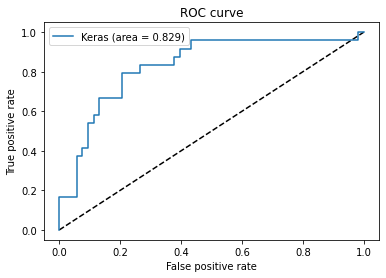

In [11]:
predictor.plot_roc()

In [12]:
predictor.get_metrics()

AUC 0.8294025157232705
Specificity: tf.Tensor(0.8490566021715913, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.6666666638888888, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6666666638888888, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8490566021715913, shape=(), dtype=float64)
